# BDLOB Implementation

A PyTorch implementation of Bayesian DeepLOB with uncertainty estimation through dropout layers.


### References

[1] Ntakaris, A., Magris, M., Kanniainen, J., Gabbouj, M., & Iosifidis, A. (2018). Benchmark dataset for mid-price forecasting of limit order book data with machine learning methods. *Journal of Forecasting*, 37(8), 852-866. https://doi.org/10.1002/for.2543  
**Dataset:** [FI-2010 Dataset](https://etsin.fairdata.fi/dataset/73eb48d7-4dbc-4a10-a52a-da745b47a649)  
**Preprocessed Version:** [Google Drive Link](https://drive.google.com/drive/folders/1Xen3aRid9ZZhFqJRgEMyETNazk02cNmv?usp=sharing)

[2] Zhang, Z., Zohren, S., & Roberts, S. (2018). DeepLOB: Deep convolutional neural networks for limit order book forecasting. *IEEE Transactions on Signal Processing*, 67(11), 3001-3012. https://doi.org/10.1109/TSP.2019.2902160  
**Original Implementation:** [DeepLOB GitHub Repository](https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books)

[3] Zhang, Z., Zohren, S., & Roberts, S. (2018). BDLOB: Bayesian deep convolutional neural networks for limit order books. *Third Workshop on Bayesian Deep Learning (NeurIPS 2018)*, Montreal, Canada. https://arxiv.org/abs/1811.10041


### Environment Setup

In [2]:
import os
from datetime import datetime
import pickle
from pathlib import Path
from zipfile import ZipFile
import urllib.request
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data
!pip install torchinfo
from torchinfo import summary

### Configuration

Initial attempts learning rate with 0.01 as per DeepLOB paper specifications(Zhang et al., 2018) but failed to yield learning convergence.

Model architecture parameters (T = sequence length, hidden layers, hardcoded on BayesianDeepLOB class) follow original implementation from Zhang et al.(2018).

In [3]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.0001 # Matches implementation from DeepLOB repository

PATIENCE = 50

USE_GOOGLE_DRIVE = True

TARGET_DIR = Path("data")

MODEL_WEIGHT_DIR = Path("model_weights")
MODEL_WEIGHT_DIR.mkdir(exist_ok=True)

DATA_URL = "https://raw.githubusercontent.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books/master/data/data.zip"
DOWNLOAD_FILE_NAME = "data.zip"

IS_COLAB = "COLAB_RELEASE_TAG" in os.environ

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Data Loading & Preprocessing

In [4]:
def setup_environment():
    """
    Configure environment for Colab or local execution
    """
    if IS_COLAB and USE_GOOGLE_DRIVE:
        from google.colab import drive
        drive.mount('/content/drive')
        data_dir = Path("/content/drive/MyDrive/data")
        model_weight_dir = Path("/content/drive/MyDrive/model_weights")
        data_dir.mkdir(exist_ok=True)
        model_weight_dir.mkdir(exist_ok=True)
        return data_dir, model_weight_dir
    return Path.cwd() / TARGET_DIR, Path.cwd() / MODEL_WEIGHT_DIR

def fetch_data(target_dir: Path):
    """Download and extract data"""
    target_dir.mkdir(exist_ok=True)
    zip_path = target_dir / DOWNLOAD_FILE_NAME

    # Download only if needed
    if not zip_path.exists():
        print("Downloading dataset...")
        urllib.request.urlretrieve(DATA_URL, zip_path)

    # Extract only if needed
    extracted_flag = target_dir / ".extracted"
    if not extracted_flag.exists():
        print("Extracting data...")
        with ZipFile(zip_path) as zf:
            zf.extractall(target_dir)
        extracted_flag.touch()

In [5]:
data_dir, weight_dir = setup_environment()
fetch_data(data_dir)
print(f"Data ready at: {data_dir.resolve()}")

Mounted at /content/drive
Data ready at: /content/drive/MyDrive/data


The FI-2010 dataset contains 149-dimensional sequential data points (N samples). Following Zhang et al.'s DeepLOB(2018) methodology, we utilize the first 40 features capturing bid/ask prices and volumes, with the final 5 dimensions reserved for label information. Batch size selection(32) aligns with the experimental setup described in the DeepLOB(Zhang et al., 2018).

In [6]:
"""
Modified from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
train_data_dir = data_dir / 'Train_Dst_NoAuction_DecPre_CF_7.txt'
test_data_dir = [data_dir / 'Test_Dst_NoAuction_DecPre_CF_7.txt', data_dir / 'Test_Dst_NoAuction_DecPre_CF_8.txt', data_dir / 'Test_Dst_NoAuction_DecPre_CF_9.txt']

dec_data = np.loadtxt(train_data_dir)
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test = np.hstack([np.loadtxt(test_data_dir[0]), np.loadtxt(test_data_dir[1]), np.loadtxt(test_data_dir[2])])

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [7]:

print("price bid")
display(dec_train[0:40:4,0])
print("-"*50)

print("volume bid")
display(dec_train[1:40:4,0])
print("-"*50)

print("price ask")
display(dec_train[2:40:4,0])
print("-"*50)

print("volume ask")
display(dec_train[3:40:4,0])
print("-"*50)

print("label")
print(dec_train[-5:,0])
print(dec_train[-5:,1])
print(dec_train[-5:,2])

price bid


array([0.2615, 0.2618, 0.2619, 0.262 , 0.2621, 0.2623, 0.2625, 0.2626,
       0.2629, 0.2633])

--------------------------------------------------
volume bid


array([0.00353, 0.002  , 0.00164, 0.00532, 0.00151, 0.00837, 0.0015 ,
       0.00787, 0.00146, 0.00311])

--------------------------------------------------
price ask


array([0.2606, 0.2604, 0.2602, 0.26  , 0.2599, 0.2595, 0.2593, 0.2591,
       0.2588, 0.2579])

--------------------------------------------------
volume ask


array([0.00326, 0.00682, 0.00786, 0.00893, 0.00159, 0.001  , 0.00143,
       0.00134, 0.00123, 0.00128])

--------------------------------------------------
label
[2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2.]
[3. 3. 2. 2. 2.]


In [8]:
"""
Copied from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [9]:
class Dataset(data.Dataset):
    """
    Characterizes a dataset for PyTorch

    Copied from DeepLOB implementation:
      https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
    Original work by Zhang et al. (2018)
    """
    def __init__(self, data, k, num_classes, T):
        """Initialization
        k: prediction horizon
        num_classes: number of classes eg)3 : down, neutral, up
        T: number of time steps used in CNN
        """

        self.k = k
        self.num_classes = num_classes
        self.T = T

        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [10]:
"""
Copied from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [11]:
"""
Copied from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

tensor([[[[1.2400e-01, 2.5750e-02, 1.2370e-01,  ..., 5.1250e-02,
           1.2280e-01, 3.0000e-01],
          [1.2400e-01, 2.5750e-02, 1.2370e-01,  ..., 5.1250e-02,
           1.2280e-01, 3.0000e-01],
          [1.2400e-01, 3.0750e-02, 1.2370e-01,  ..., 5.1250e-02,
           1.2280e-01, 3.0000e-01],
          ...,
          [1.2390e-01, 4.9600e-03, 1.2380e-01,  ..., 2.1000e-02,
           1.2260e-01, 7.0000e-03],
          [1.2400e-01, 4.0000e-05, 1.2380e-01,  ..., 5.1250e-02,
           1.2260e-01, 7.0000e-03],
          [1.2400e-01, 4.0000e-05, 1.2380e-01,  ..., 5.1250e-02,
           1.2260e-01, 7.0000e-03]]]], dtype=torch.float64)
tensor([2.], dtype=torch.float64)
torch.Size([1, 1, 100, 40]) torch.Size([1])


### Bayesian DeepLOB Model



Post-inception module dropout layers were incorporated following Bayesian DeepLOB specifications (Zhang et al., 2018), implementing the dropout probability of p=0.2 for uncertainty estimation.

In [12]:
"""
Modified from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
class BayesianDeepLOB(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len

        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception modules
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        self.dropout = nn.Dropout(p=0.2)  # Dropout layer

        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

        x = self.dropout(x)  # Apply dropout

        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))

        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)

        return forecast_y


In [13]:
"""
Modified from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
model = BayesianDeepLOB(y_len = dataset_train.num_classes)
model.to(device)
summary(model, (1, 1, 100, 40))

Layer (type:depth-idx)                   Output Shape              Param #
BayesianDeepLOB                          [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 94, 20]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 20]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 20]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 20]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 20]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 20]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 20]           64
│    └─Conv2d: 2-7                       [1, 32, 94, 20]           4,128
│    └─LeakyReLU: 2-8                    [1, 32, 94, 20]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 94, 20]           64
├─Sequential: 1-2                        [1, 32, 88, 10]           --
│    └─Conv2d: 2-10                      [1, 32, 94, 10]           2,080
│    └

### Training

In [14]:
"""
Modified from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
"""
Modified from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs, patience):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        if test_loss < best_test_loss:
            weight_path = os.path.join(weight_dir, f'{model.__class__.__name__}_weights.pth')
            torch.save(model, weight_path)
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

        # early stop
        if it - best_test_epoch > patience:
            print('early stop')
            break

    return train_losses, test_losses

In [16]:
weight_path = os.path.join(weight_dir, 'BayesianDeepLOB_weights.pth')

if not os.path.isfile(weight_path):
  # train the model
  train_losses, val_losses = batch_gd(model, criterion, optimizer,
                                    train_loader, val_loader, epochs=EPOCHS, patience=PATIENCE)

  with open(data_dir / 'results_training.csv', 'w') as f:
    f.write('Epoch,Train Loss,Validation Loss\n')
    for i in range(len(train_losses)):
      f.write(f'{i+1},{train_losses[i]},{val_losses[i]}\n')
else:
  model = torch.load(weight_path, map_location=device)
  model
  with open(data_dir / 'results_training.csv', 'r') as f:
    train_losses = []
    val_losses = []
    for line in f.readlines():
      if line.startswith('Epoch'):
        continue
      epoch, train_loss, val_loss = line.strip().split(',')
      train_losses.append(float(train_loss))
      val_losses.append(float(val_loss))
  train_losses = np.array(train_losses)
  val_losses = np.array(val_losses)



<ipython-input-16-a3aae56a4e74>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(weight_path, map_location=device)


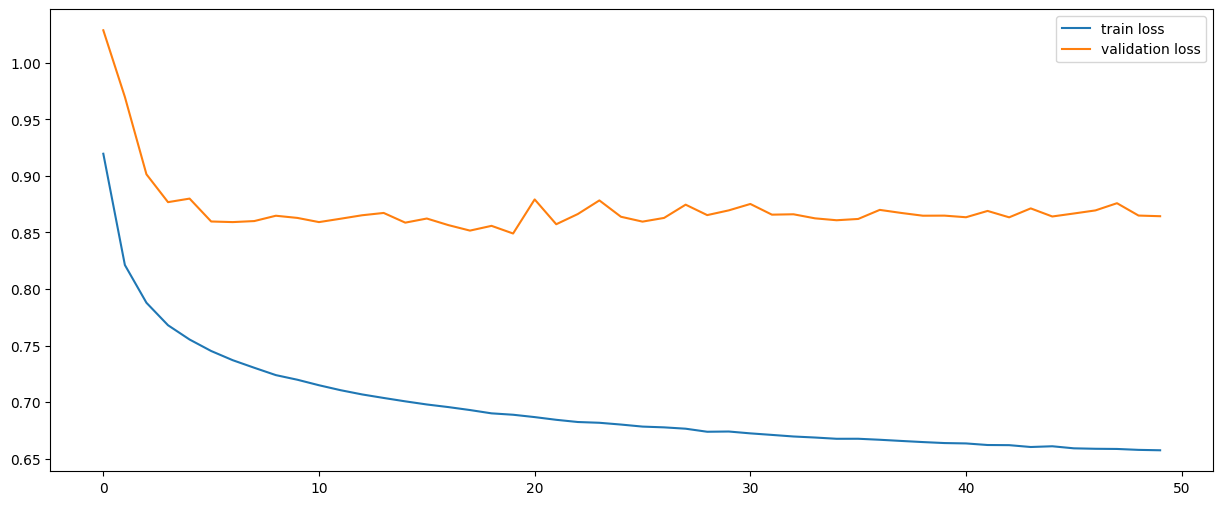

In [18]:
"""
Copied from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

### Evaluation

Initial model evaluation was conducted with dropout disabled to establish deterministic baseline performance. Comparative analysis against DeepLOB benchmark metrics (available in the original repository) suggests marginal performance improvements, though rigorous statistical validation remains pending.

In [17]:
"""
Modified from DeepLOB implementation:
  https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books
Original work by Zhang et al. (2018)
"""
all_targets = []
all_predictions = []

for inputs, targets in tqdm(test_loader):
    model.train(False)
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)

print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

100%|██████████| 4359/4359 [00:19<00:00, 219.98it/s]


accuracy_score: 0.7650263821977518
              precision    recall  f1-score   support

           0     0.7269    0.7881    0.7563     47915
           1     0.8422    0.7508    0.7939     48050
           2     0.7354    0.7553    0.7452     43523

    accuracy                         0.7650    139488
   macro avg     0.7682    0.7647    0.7651    139488
weighted avg     0.7693    0.7650    0.7658    139488



#### Evaluate the Uncertainty

To estimate predictive uncertainty, following the BDLOB, we employed Monte Carlo dropout during inference (100 stochastic forward passes) as proposed by Gal & Ghahramani (2016). Prediction entropy was calculated per sample using:
$$H(y\vert x)=-\sum_c\hat p _c \log \hat p_c$$
represents the mean class probability over stochastic iterations.

In [22]:
if model is None:
  path_weight = os.path.join(weight_dir, f'BayesianDeepLOB_weights.pth')
  model = torch.load(path_weight)

files = os.listdir(data_dir)

M = 100 # number of stochastic forward tests.
if 'predictions_data.pkl' not in files:
  predictions_data = None
else:
  with open(data_dir / 'predictions_data.pkl', 'rb') as f:
    predictions_data = pickle.load(f)

if 'entropies_predictions.pkl' not in files:
  entropies_predictions = None
else:
  with open(data_dir / 'entropies_predictions.pkl', 'rb') as f:
    entropies_predictions = pickle.load(f)

if 'all_targets.pkl' not in files:
  all_targets = np.array([])
else:
  with open(data_dir / 'all_targets.pkl', 'rb') as f:
    all_targets = pickle.load(f)

if predictions_data is None or entropies_predictions is None or all_targets is None:
  # for test of code just use 200 data in test_loader
  # test_size = 200
  for inputs, targets in tqdm(test_loader):
    # test_size -= 1
    # if test_size < 0:
    #   break
    predictions_stochastic = np.zeros((M,targets.shape[0], 3))

    # Set dropout enabled
    model.train(True)

    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    for m in range(M):

      # Forward pass
      outputs = model(inputs)

      # Get prediction
      # torch.max returns both max and argmax
      _, predictions = torch.max(outputs, 1)

      predictions_stochastic[m] = outputs.cpu().detach().numpy()

    all_targets = np.concatenate((all_targets, targets.cpu().detach().numpy()))
    prediction = np.mean(predictions_stochastic, axis=0)

    # Handle the first iteration for each predictions_data and entropies_predictions
    if predictions_data is None:
          predictions_data = prediction
    else:
          predictions_data = np.concatenate((predictions_data, prediction), axis=0)

    entropies = -np.sum(predictions_stochastic * np.log(predictions_stochastic + 1e-8), axis=0)

      # Get the index of the most confident class for each prediction
    most_confident_class_indices = np.argmax(np.mean(predictions_stochastic, axis=0), axis=1)

    # Extract the entropy of the most confident class
    prediction_entropy = entropies[np.arange(len(most_confident_class_indices)), most_confident_class_indices]
    if entropies_predictions is None:
        entropies_predictions = prediction_entropy
    else:
        entropies_predictions = np.concatenate((entropies_predictions, prediction_entropy), axis=0)

  with open(data_dir / 'predictions_data.pkl', 'wb') as f:
      pickle.dump(predictions_data, f)

  with open(data_dir / 'all_targets.pkl', 'wb') as f:
      pickle.dump(all_targets, f)

  with open(data_dir / 'entropies_predictions.pkl', 'wb') as f:
      pickle.dump(entropies_predictions, f)

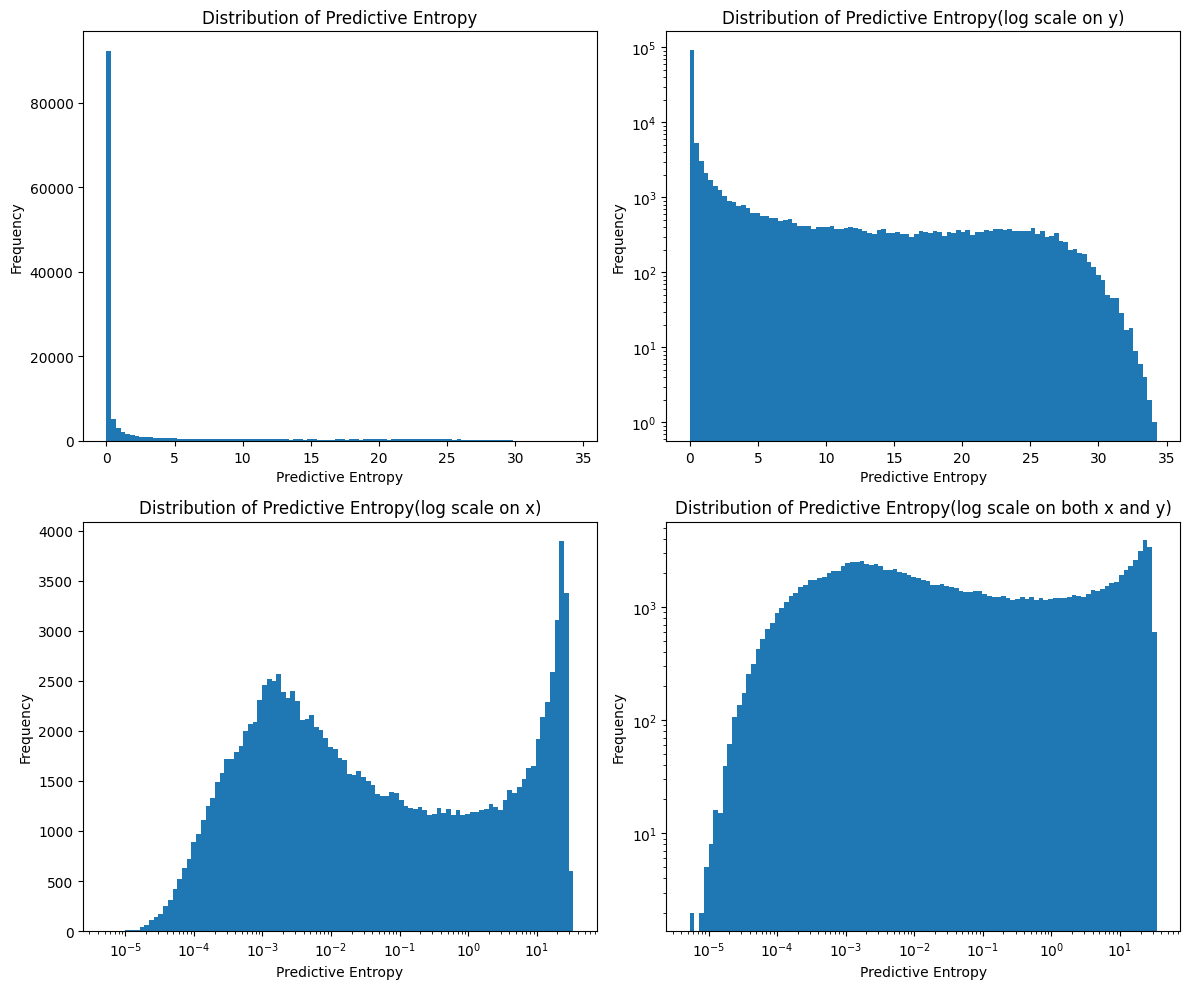

In [44]:
plt.figure(figsize=(12, 10))

# Analyze entropy distribution
plt.subplot(2, 2, 1)
plt.hist(entropies_predictions, bins=100)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy')

# log scale on y
plt.subplot(2, 2, 2)
plt.xscale('linear')
plt.yscale('log')
plt.hist(entropies_predictions, bins=100)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy(log scale on y)')

# log scale on x
plt.subplot(2, 2, 3)
plt.xscale('log')
bins = np.logspace(np.log10(min(entropies_predictions)), np.log10(max(entropies_predictions)), 100)
plt.hist(entropies_predictions, bins=bins)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy(log scale on x)')

# log scale on both x and y
plt.subplot(2, 2, 4)
plt.xscale('log')
plt.yscale('log')
bins = np.logspace(np.log10(min(entropies_predictions)), np.log10(max(entropies_predictions)), 100)
plt.hist(entropies_predictions, bins=bins)
plt.xlabel('Predictive Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Predictive Entropy(log scale on both x and y)')
plt.tight_layout()
plt.show()


#### Confidence Analysis

To empirically validate the relationship between predictive uncertainty and model reliability, we conducted an analysis addressing two key questions:

Question 1: Do low-entropy (high-confidence) predictions exhibit higher accuracy?

Question 2: How does uncertainty thresholding impact prediction coverage (recall)?

We developed an analytical framework to evaluate precision and recall across predictive entropy thresholds. By incrementally filtering predictions based on entropy values (from 1% to 100% of the observed maximum entropy), we quantified:

Precision: Accuracy of retained predictions at each threshold

Recall: Proportion of total true positives captured

---

On high confidence(low entropy), precision and recall remain elevated, and both metrics exhibit steep declines (0-3), confirming that low-entropy predictions(0-1) are statistically more reliable.

When including all predictions (no thresholding), performance matches conventional evaluation metrics, serving as a reference for coverage-accuracy tradeoffs.

Practitioners can dynamically adjust entropy thresholds to balance reliability (precision) and coverage (recall) based on risk tolerance.

The entropy 0-3 transition zone highlights potential areas for model improvement via targeted data augmentation or architectural refinement.

100%|██████████| 100/100 [00:00<00:00, 646.70it/s]


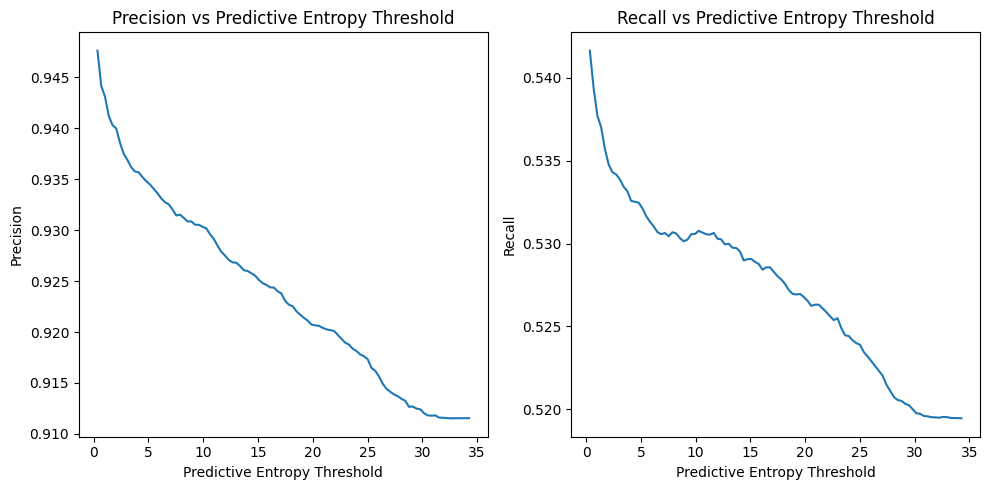

In [47]:

# Calculate the maximum entropy
max_entropy = np.max(entropies_predictions)

# Create thresholds from 1/100 of the maximum entropy to the maximum entropy
thresholds = max_entropy * np.linspace(0.01, 1, 100)

precisions = []
recalls = []
predictions = predictions_data.argmax(axis=1)
labels = all_targets
entropies = entropies_predictions

for threshold in tqdm(thresholds):
    confident_predictions = predictions[entropies <= threshold]
    confident_labels = labels[entropies <= threshold]

    if len(confident_predictions) > 0:
        # Calculate precision and recall for this threshold
        true_positives = np.sum((confident_predictions == 1) & (confident_labels == 1))
        false_positives = np.sum((confident_predictions == 1) & (confident_labels == 0))
        false_negatives = np.sum((confident_predictions == 0) & (confident_labels == 1))

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
    else:
        precisions.append(0)
        recalls.append(0)

# Plot precision and recall vs entropy thresholds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precisions)
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Predictive Entropy Threshold')

plt.subplot(1, 2, 2)
plt.plot(thresholds, recalls)
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Predictive Entropy Threshold')

plt.tight_layout()
plt.show()

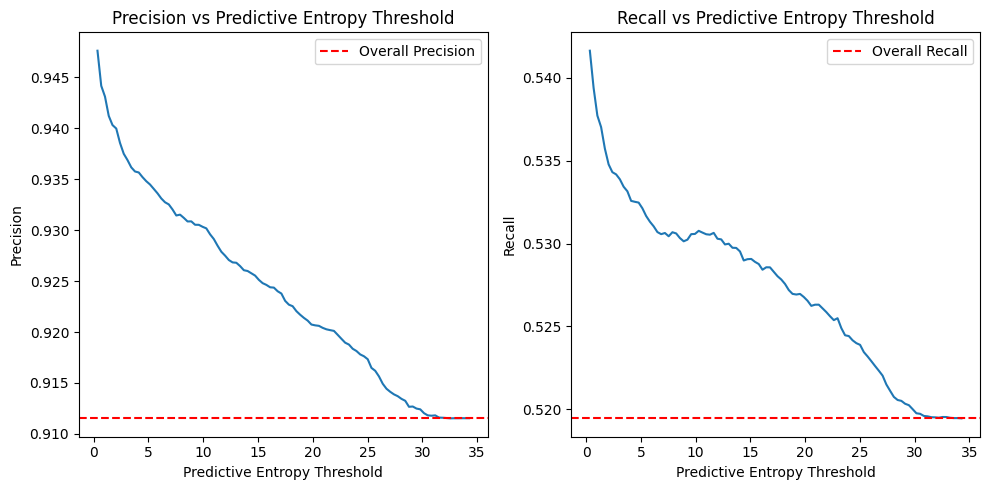

In [40]:
# Calculate overall precision and recall without entropy thresholding
overall_true_positives = np.sum((predictions == 1) & (labels == 1))
overall_false_positives = np.sum((predictions == 1) & (labels == 0))
overall_false_negatives = np.sum((predictions == 0) & (labels == 1))

overall_precision = overall_true_positives / (overall_true_positives + overall_false_positives) if (overall_true_positives + overall_false_positives) > 0 else 0
overall_recall = overall_true_positives / (overall_true_positives + overall_false_negatives) if (overall_true_positives + overall_false_negatives) > 0 else 0

# Plot precision and recall vs entropy thresholds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precisions)
plt.axhline(y=overall_precision, color='r', linestyle='--', label='Overall Precision')
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Predictive Entropy Threshold')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(thresholds, recalls)
plt.axhline(y=overall_recall, color='r', linestyle='--', label='Overall Recall')
plt.xlabel('Predictive Entropy Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Predictive Entropy Threshold')
plt.legend()

plt.tight_layout()
plt.show()
